# GA with numpy functions

By: Ximena Paniagua S.

### Importar las librerías necesarias

*Import the necessary libraries*

In [1]:
import numpy as np
import random
from sympy import symbols, parse_expr, lambdify, srepr, sympify
import matplotlib.pyplot as plt
import time
x = symbols('x')

import logging
# Configuración básica del registro
logging.basicConfig(level=logging.INFO)

import warnings

# Ignorar todas las advertencias de RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Se extraen los datos de el parámetro de Hubble que se ajustarán a una función por encontrar.

*Hubble parameter data is extracted to be fitted to a function to find.*

In [2]:
# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

La clase Create_Individual crea un individuo con un numero de cromosomas específico tal que: 

1. Si se le entregan 5 cromosomas el individuo tendrá 6. 
2. El individuo será una lista del tipo: ['x', '+', '1'] donde cada string es un cromosoma.
3. Los índices pares y el $0$ son expresiones. 
4. Los índices impares partiendo del $1$ son operaciones.
5. Si se le entrega a Create_Individual un individuo ya creado desde antes, devuelve ese individuo. 
6. Cabe recalcar que en un inicio el individuo es del tipo Create_Individual, y el método obtain_expression() entrega la expresion como una lista de strings. 

The Create_Individual class creates an individual with a specific chromosome number such that:

1. If 5 chromosomes are given, the individual will have 6.
2. The individual will be a list of the type: ['x', '+', '1'] where each string is a chromosome.
3. The even indices and $0$ are expressions.
4. Odd indices starting from $1$ are operations.
5. If an individual already created before is given to Create_Individual, it returns that individual.
6. It should be remembered that initially the individual is of type Create_Individuals, and the obtain_expression() method delivers the expression as a list of strings.

In [3]:
class Create_Individual:
    def __init__(self, params, expression = None):
        if expression is None:
            genes = [np.random.choice(params['genes']) for _ in range(0, params['number_of_genes'] + 1, 2)]
            operations = [np.random.choice(params['operaciones']) for _ in range(1, params['number_of_genes'] + 1, 2)]
            self.expression = [valor for par in zip(genes, operations) for valor in par] + [np.random.choice(params['genes'])] #se le suma un gen para que quede una funcion al final/No cambia el numero de cromosomas
        else:
            self.expression = [valor for valor in expression]

    def obtain_expressions(self): #da los cromosomas del individuo
        return self.expression

La clase Create_Generation crea una población inicial, la cual pasa por los siguientes procesos: 

1. Se eligen los padres más aptos de la poblacion inicial
2. Se combinan para generar cierta cantidad de hijos por cada uno
3. Dentro de tales hijos, cierta cantidad se muta

*The Create_Generation class creates an initial population, which goes through the following processes:*

1. *The fittest parents are chosen from the initial population*
2. *They combine to generate a certain number of children for each one*
3. *Within such children, a certain amount is mutated*

In [4]:
class Create_Generation:
    def __init__(self, ind_parameters, pop_parameters, fitness_function, expression = None):
        #Crea una poblacion inicial
        self.size = pop_parameters['size'] # Tamaño poblacion
        self.initial_poblation = ind_parameters['genes']
        self.initial_operation = ind_parameters['operaciones']
        self.mutation_rate = pop_parameters['mutation_rate']
        self.selection_rate = pop_parameters['selection _rate']
        self.fitness_function = fitness_function 

        if expression == None:
            self.individuals = [Create_Individual(ind_parameters)  for _ in range(self.size)]
        else:
            self.individuals = [Create_Individual(ind_parameters, expression = expression[i]) for i in range(len(expression))]

    def evaluar_expresion(self, x, expresion):
        resultado = expresion[0](x)

        i = 1
        while i < len(expresion):
            operador = expresion[i]
            funcion = expresion[i + 1]

            if operador == '+':
                resultado = resultado + funcion(x)
            elif operador == '-':
                resultado = resultado - funcion(x)
            elif operador == '*':
                resultado = resultado * funcion(x)
            elif operador == '/':
                resultado = resultado / funcion(x)
            elif operador == '**':
                resultado = resultado ** funcion(x)
            elif operador == 'comp':
                resultado = funcion(resultado)
            
            i += 2

        return resultado

    def child(self, parent, parent2, crossover_point):
        kid = []
        if len(parent) == 1 and len(parent2) == 1:
            kid = parent
        elif len(parent) == 1:
            kid[:0] = parent
            kid[1:] = parent2[1:]
        elif len(parent2) == 1:
            kid[:0] = parent2
            kid[1:] = parent[1:]
        else:                
            kid[:crossover_point] = parent[:crossover_point]
            kid[crossover_point:] = parent2[crossover_point:]
        return kid

    def get_parents(self, poblacion) -> np.array: # pares son expresiones e impares son operaciones
        n_parents = int((self.selection_rate)/100 * len(poblacion))
        parents = []
        for expresion in poblacion:
            parents.append(expresion.obtain_expressions())
        parents_evaluate = [self.evaluar_expresion(z, expresion) for expresion in parents]
        Chi = [self.fitness_function(function) for function in parents_evaluate]
        Minor_Chi = min(Chi)
        sorted_parents = [x for _, x in sorted(zip(Chi, parents), key=lambda pair: pair[0])]
        selected_parents = sorted_parents[:n_parents]
        non_selectec_parents = sorted_parents[n_parents:]
        r1 = random.random()
        r2 = random.random()
        no_apto = random.choice(non_selectec_parents)
        no_apto_2 = random.choice(non_selectec_parents)
        no_apto_3 = random.choice(non_selectec_parents)
        if r1>r2:
            Selected_parents = selected_parents + [no_apto] + [no_apto_2] + [no_apto_3]
        else:
            Selected_parents = selected_parents
        return Selected_parents, Minor_Chi
    
    def crossover(self, parents: np.array) -> np.array:
        offspring = []
        for parent in parents:
            crossover_point = random.choice(range(1, len(parents))) #se elige un numero entre 1 y el penultimo cormosoma para que siempre haya crossover
            parent2 = random.choice(parents)
            parent3 = random.choice(parents)
            parent4 = random.choice(parents)
            parent5 = random.choice(parents)
            parent6 = random.choice(parents)
            kid = self.child(parent, parent2, crossover_point)
            kid2 = self.child(parent, parent3, crossover_point)
            kid3 = self.child(parent, parent4, crossover_point)
            kid4 = self.child(parent, parent5, crossover_point)
            kid5 = self.child(parent, parent6, crossover_point)
            offspring.append(kid)
            offspring.append(kid2)
            offspring.append(kid3)
            offspring.append(kid4)
            offspring.append(kid5)

        return offspring
    
    def mutate(self, offspring_crossover) -> np.array: # contras: a veces se pude mutar el mismo individuo
        num_mutations = int(len(offspring_crossover)*self.mutation_rate/100)
        for num in range(num_mutations):
            idx_mutation = random.choice(range(len(offspring_crossover))) # se elige individuo que se va a mutar
            ind_mutate = offspring_crossover[idx_mutation]
            g = random.choice(range(len(ind_mutate))) #numero de gen que se va a mutar
            if g % 2 == 0 or g==0:
                new_gen = random.choice(self.initial_poblation)
                ind_mutate[g] = new_gen
            else:
                new_gen = random.choice(self.initial_operation)
                ind_mutate[g] = new_gen
        return offspring_crossover

La clase Evolución itera sobre las generaciones requeridas hasta llegar a la última. Durante esta iteración se guardan los menores $\chi^2$ de cada generación. Finalmente devuelve la última generación y los $\chi^2$ antes guardados. 

*The Evolution class iterates over the required generations until it reaches the last one. During this iteration the smallest $\chi^2$ of each generation are saved. Finally it returns the last generation and the previously saved $\chi^2$.*

In [5]:
class Evolution:
    def __init__(self, gen_parameter, ind_parameters, pop_params, fitness_function): #gen_parameter = {'selection_rate' : 20, 'mutation_rate' : 10, 'num_generations': 100}
        self.selection_rate = gen_parameter['selection_rate']
        self.mutation_rate = gen_parameter['mutation_rate']
        self.num_generations = gen_parameter['num_generations']
        self.fitness_function = fitness_function
        self.ind_parameters = ind_parameters
        self.pop_params = pop_params

    def Iteracion(self):
        inicio_tiempo = time.time()
        Generations = []
        Chi = []
        for n in range(self.num_generations):
            logging.info(f'Número de la generación: {n}')
            if n == 0: 
                A = Create_Generation(self.ind_parameters, self.pop_params, self.fitness_function)
                initial_poblation = A.individuals
                parents, minor_chi = A.get_parents(initial_poblation)
                Chi.append(minor_chi)
                crossover = A.crossover(parents)
                mutation = A.mutate(crossover)
                Generations.append(mutation)
            else:
                A = Create_Generation(self.ind_parameters, self.pop_params, self.fitness_function, expression = Generations[n-1])
                poblation = A.individuals
                parents, minor_chi = A.get_parents(poblation)
                Chi.append(minor_chi)
                crossover = A.crossover(parents)
                mutation = A.mutate(crossover)
                Generations.append(mutation)
        
        tiempo_transcurrido = time.time() - inicio_tiempo
        logging.info(f"The evolution took {tiempo_transcurrido} seconds in execute")
        return Generations[-1], Chi

### Prueba del algoritmo

*Algorithm test*

In [6]:
# Se definen los cromosomas iniciales

def ident(x):
    return (x+1)

def expo(x):
    return x**x

def poli2(x):
    return x**2

def poli3(x):
    return x**3

def coeficiente2(x):
    return 2

def coeficiente3(x):
    return 3

def Chi2(*x): # Con numpy array (disminuye la cantidad de errores)
    array =  np.sum(((np.array(H).astype(np.float64) - np.array(x).astype(np.float64))/np.array(desv).astype(np.float64))**2)
    return array.tolist()

def Chi(*x): 
    return np.sum(((H - x)/desv)**2)

Genes = [ident, expo, coeficiente2]
print(Genes)

[<function ident at 0x0000010F622FEE80>, <function expo at 0x0000010F622FED40>, <function coeficiente2 at 0x0000010F743EB100>]


In [16]:
# Se definen los diccionarios que se les pasaran a las clases

pop_params = {'size': 100,'selection _rate': 20, 'mutation_rate' : 15}
ind_parameters = {'genes': Genes, 'operaciones': ['+', '-', '*',  '/', '**','comp'], 'number_of_genes': 10}
gen_parameter = {'selection_rate' : 20, 'mutation_rate' : 15, 'num_generations' : 500}

intento1 = Evolution(gen_parameter, ind_parameters, pop_params, Chi)

ultima_generacion, chi = intento1.Iteracion()

INFO:root:Número de la generación: 0
INFO:root:Número de la generación: 1
INFO:root:Número de la generación: 2
INFO:root:Número de la generación: 3
INFO:root:Número de la generación: 4


INFO:root:Número de la generación: 5
INFO:root:Número de la generación: 6
INFO:root:Número de la generación: 7
INFO:root:Número de la generación: 8
INFO:root:Número de la generación: 9
INFO:root:Número de la generación: 10
INFO:root:Número de la generación: 11
INFO:root:Número de la generación: 12
INFO:root:Número de la generación: 13
INFO:root:Número de la generación: 14
INFO:root:Número de la generación: 15
INFO:root:Número de la generación: 16
INFO:root:Número de la generación: 17
INFO:root:Número de la generación: 18
INFO:root:Número de la generación: 19
INFO:root:Número de la generación: 20
INFO:root:Número de la generación: 21
INFO:root:Número de la generación: 22
INFO:root:Número de la generación: 23
INFO:root:Número de la generación: 24
INFO:root:Número de la generación: 25
INFO:root:Número de la generación: 26
INFO:root:Número de la generación: 27
INFO:root:Número de la generación: 28
INFO:root:Número de la generación: 29
INFO:root:Número de la generación: 30
INFO:root:Número 

### Evaluación del $\chi^2$

*Evaluation of $\chi^2$*

The minor chi^2 was: 19.716406687148574


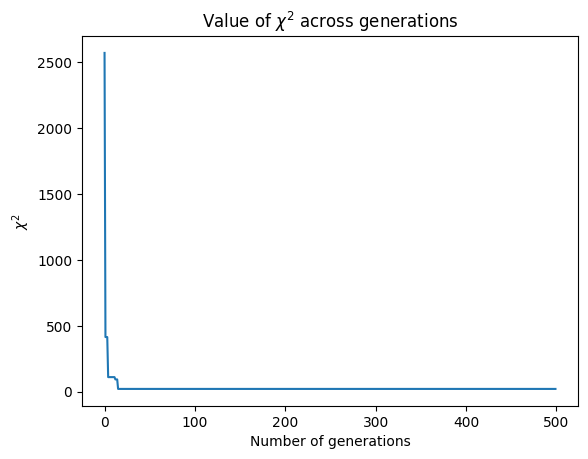

In [17]:
minor_chi = chi
print('The minor chi^2 was: ' + str(min(minor_chi)))
num_generaciones = np.arange(0, len(minor_chi), 1)
plt.plot(num_generaciones, minor_chi)
plt.xlabel('Number of generations')
plt.ylabel('$\chi^2$')
plt.title('Value of $\chi^2$ across generations')
plt.show()

## Best fit encontradas (proceso por optimizar)

### *Best fit found (process to be optimized)*

Hay que calcular manualmente la best fit function encontrada, en el sentido de que el código entrega una lista de la forma: 

[<function coeficiente2 at 0x00000136257E7560>, '+', <function ident at 0x00000136136FEB60>, '*', <function coeficiente2 at 0x00000136257E7560>, '**', <function coeficiente2 at 0x00000136257E7560>, '-', <function coeficiente2 at 0x00000136257E7560>, '*', <function coeficiente2 at 0x00000136257E7560>], 

y hay que tomar en cuenta que el código procesa las expresiones de izquierda a derecha en importancia. Por ejemplo: x + 2 * 4 significa, para el código, (x+2)*4. La composición también se cuenta como una operación. 

____________________________________________________________________________________________________________________________________________

*You have to manually calculate the best fit function found, in the sense that the code provides a list of the form:*

[<function coefficient2 at 0x00000136257E7560>, '+', <function ident at 0x00000136136FEB60>, '*', <function coefficient2 at 0x00000136257E7560>, '**', <function coefficient2 at 0x00000136257E7560>, '-', <function coefficient2 at 0x00000136257E7560>, '*', <function coefficient2 at 0x00000136257E7560>],

*and it must be taken into account that the code processes expressions from left to right in importance. For example: $x + 2 \cdot 4$ means, for the code, $(x+2)\cdot4$. Composition is also counted as an operation.*

In [18]:
def evaluar_expresion(z, expresion):
    resultado = expresion[0](z)

    i = 1
    while i < len(expresion):
        operador = expresion[i]
        funcion = expresion[i + 1]

        if operador == '+':
            resultado = resultado + funcion(z)
        elif operador == '-':
            resultado = resultado - funcion(z)
        elif operador == '*':
            resultado = resultado * funcion(z)
        elif operador == '/':
            resultado = resultado / funcion(z)
        elif operador == '**':
            resultado = resultado ** funcion(z)
        elif operador == 'comp':
            resultado = funcion(resultado) 

        i += 2

    return resultado

def calcular_chi(funcion_evaluada, H, desv):
     return np.sum(((H - funcion_evaluada)/desv)**2)

# Se calculan chi's y funciones de la ultima generacion (para ver las expresiones sacar # del último print)

evaluadas = []
for expresion in ultima_generacion:
     evaluadas.append(evaluar_expresion(z, expresion))

chi_evaluados = []
for evaluada in evaluadas:
     chi_evaluados.append(calcular_chi(evaluada, H, desv))

#print('Los chi de la última generación son: ' + str(chi_evaluados))
#print('La última generación es:' + str(ultima_generacion))

### Lista de funciones encontradas hasta el momento

*List of functions found so far*

In [19]:
def f1(x):
    '''
    chi = 28
    '''
    return (((3 + 3) * 3 )+ (x+1)) * (x+1) * 3

def f2(x):
    '''
    chi = 22
    '''
    return (3**3 + (x+1) + 2) * (x+1) * 2

def f3(x):
    '''
    chi = 19.71640668714861
    Generaciones = 500
    Tiempo = 26.6 s
    '''
    return (((3 / (x+1)) + 3) * (x+1) + 2) ** 2

def f4(x):
    '''
    chi = 19.72
    Generaciones = 100
    Tiempo = 4 s
    '''
    return (5 + 3*(x+1))**2

def f5(x):
    '''
    chi = 31.07962529219873
    Generaciones = 100
    Tiempo = 2 s
    '''
    return ((4 + 2*(x+1))**2)*2 - 2

def f6(x):
    '''
    chi = 27.06
    Generaciones = 100
    Tiempo = 2 s
    '''
    return 64*(x+1)

def f7(x):
    '''
    chi = 23.936801576272018
    Generaciones = 100
    Tiempo = 1.7 s
    '''
    return 2*(4 + 2*(x+1))**2 - 4

def f8(x):
    '''
    chi = 19.716406687148574
    Generaciones = 500
    Tiempo = 1.20 min
    '''
    return (5 + 3*(x+1))**2

### Comprobación de la constante  $H_0$ (mientras más cerca esté de $70$, mejor)

*Checking the constant $H_0$ (the closer it is to $70$, the better)*

In [20]:
print('Constante para f7: ' + str(f7(0)))
print('Constante para f4 (f4 = f8): ' + str(f4(0)))

Constante para f7: 68
Constante para f4 (f4 = f8): 64


### Se grafican los datos y la best fit function con menor chi encontrada hasta el momento (fue el último intento)

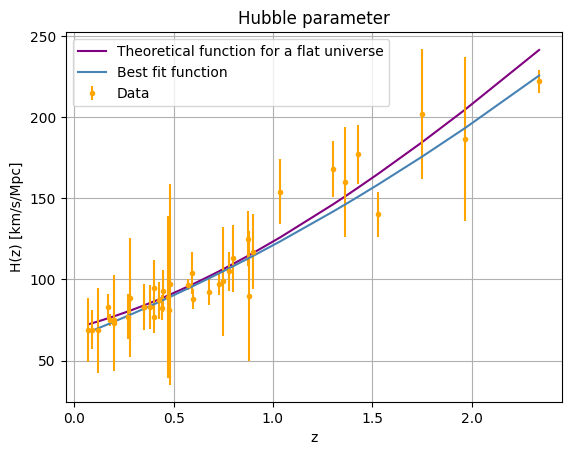

In [21]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_r-Omega_m-Omega_lambda)*(1+z)**2))

# Parámetros a usar
H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]


# Funciones teóricas para los 3 tipos de universo
H_teorico_plano = H_bm(z,O_r, O_m, O_lambda, o_DE)
H_teorico_cerrado = H_bm(z,O_r, O_m, 0.9*O_lambda, o_DE)
H_teorico_abierto = H_bm(z,O_r, O_m, 1.1*O_lambda, o_DE)

# Se grafica función teórica para universo plano vs best fit function y se añaden los datos experimentales con su error respectivo
plt.plot(z, H_teorico_plano, label = 'Theoretical function for a flat universe', color = 'purple')
plt.errorbar(z, H, yerr=desv, fmt='.', label='Data', color = 'orange')
plt.plot(z, f4(z), label= 'Best fit function', color = '#4682B4')
plt.title('Hubble parameter')
plt.xlabel('z')
plt.ylabel('H(z) [km/s/Mpc]')
plt.grid(True)
plt.legend()
plt.show()

### Bibliography: 

All this algorithm was based, globally, in the three classes created by the GA of Fernando Zepeda. GitHub link: https://github.com/Fmrhj/genetic-algorithm